<strong><b><font size="5">Time Series Analysis Using Python(AR,MA,ARMA,ARIMA,SARIMA)</font></b></strong>

# Time Series
- A time series is a sequential set of data points, measured typically over successive times. 
- It is mathematically defined as a set of vectors x(t), t = 0,1,2,... where t represents the time elapsed. 
- The variable x(t) is treated as a random variable. 
- The measurements taken during an event in a time series are arranged in a proper chronological order. 
- A time series containing records of a single variable is termed as univariate, and more than one variable a multivariate. 

# Libraries for time series 

In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

import pandas as pd
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from fbprophet import Prophet

from math import sqrt

import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns

from random import random

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

# Importing dataset


In [2]:
df = pd.read_csv('international-airline-passengers.csv',header=None)

In [3]:
df.columns = ['year','passengers']

In [4]:
df.head(3)

,year,passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132


In [8]:
print('Time period start: {}\nTime period end: {}'.format(df.year.min(),df.year.max()))

Time period start: 1949-01
Time period end: 1960-12


In [9]:
df.columns

Index(['year', 'passengers'], dtype='object')

In [10]:
df.shape

(144, 2)

# Preprocessing 

Converting to datetime format:

In [11]:
df['year'] = pd.to_datetime(df['year'], format='%Y-%m')

In [12]:
y = df.set_index('year')

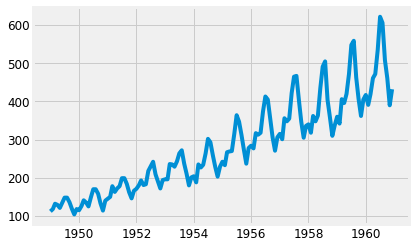

In [17]:
#y.plot(figsize=(15, 6))
plt.plot(figsize=(15, 6))
plt.plot(y.index, y.values)
plt.show()

__Reviewing plots of the density of observations can provide further insight into the structure of the data:__
- The distribution is not perfectly Gaussian (normal distribution).
- The distribution is left shifted.
- Transformations might be useful prior to modelling.

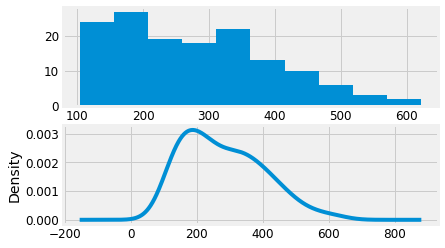

In [20]:
from pandas import Series
from matplotlib import pyplot
pyplot.figure(1)
pyplot.subplot(211)
y.passengers.hist()
pyplot.subplot(212)
y.passengers.plot(kind='kde')
pyplot.show()

__Statistical plot(Box and Whisker Plots):__
- Median values across years confirms an upwards trend
- Steady increase in the spread, or middle 50% of the data (boxes) over time
- A model considering seasonality might work well

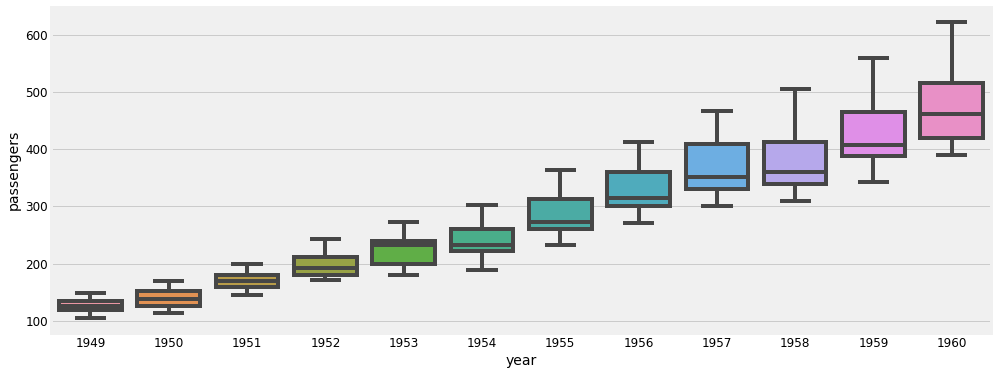

In [21]:
fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(y.passengers.index.year, y.passengers, ax=ax)

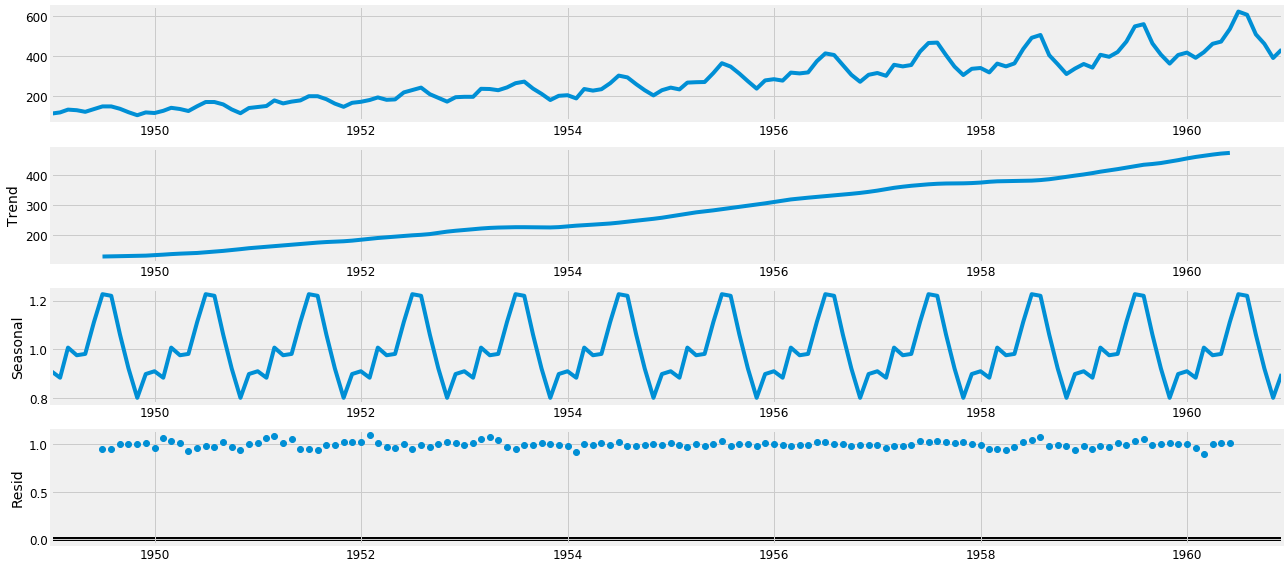

In [22]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative')
fig = decomposition.plot()
plt.show()

## Stationarity
- A Time Series is said to be stationary if its statistical properties such as mean, variance remain constant over time.
- Most of the Time Series models work on the assumption that the TS is stationary. Major reason for this is that there are many ways in which a series can be non-stationary, but only one way for stationarity.
- Intuitively, we can say that if a Time Series has a particular behaviour over time, there is a very high probability that it will follow the same in the future. 
- Also, the theories related to stationary series are more mature and easier to implement as compared to non-stationary series.

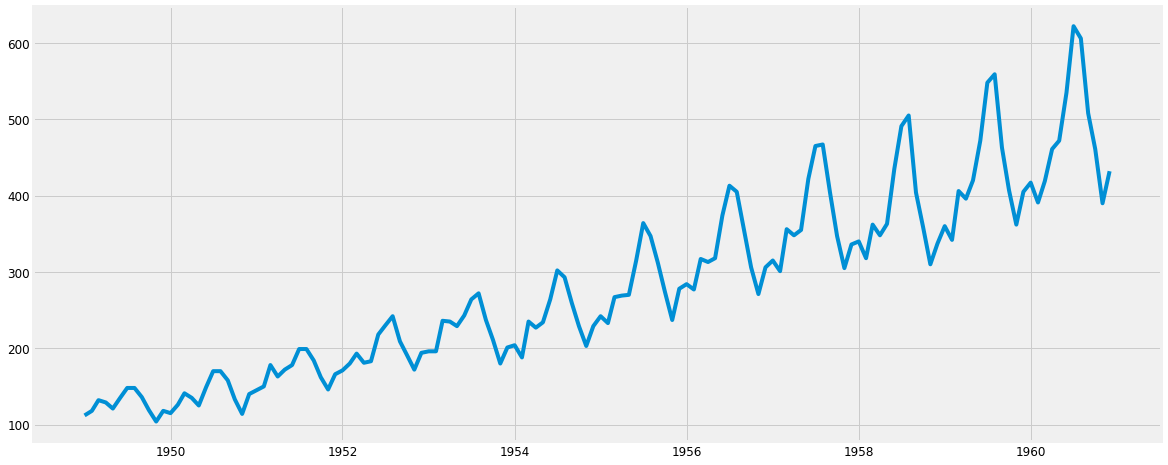

In [23]:
plt.plot(y)

__We can check stationarity using the following:__

- __ACF and PACF plots__: If the time series is stationary, the ACF/PACF plots will show a __quick drop-off in correlation__ after a small amount of lag between points.
- __Plotting Rolling Statistics__: We can plot the moving average or moving variance and see if it varies with time. Moving average/variance is for any instant ‘t’, the average/variance of the last year, i.e. last 12 months.
- __Augmented Dickey-Fuller Test:__ This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary. Refer this article for details.

### ACF and PACF plots

- Let's review the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots
- If the time series is stationary, the ACF/PACF plots will show a __quick drop-off in correlation__ after a small amount of lag between points.
- This data is non-stationary as a high number of previous observations are correlated with future values.
- Confidence intervals are drawn as a cone. 
- By default, this is set to a 95% confidence interval, suggesting that correlation values outside of this code are very likely a correlation and not a statistical fluke.
- The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags.

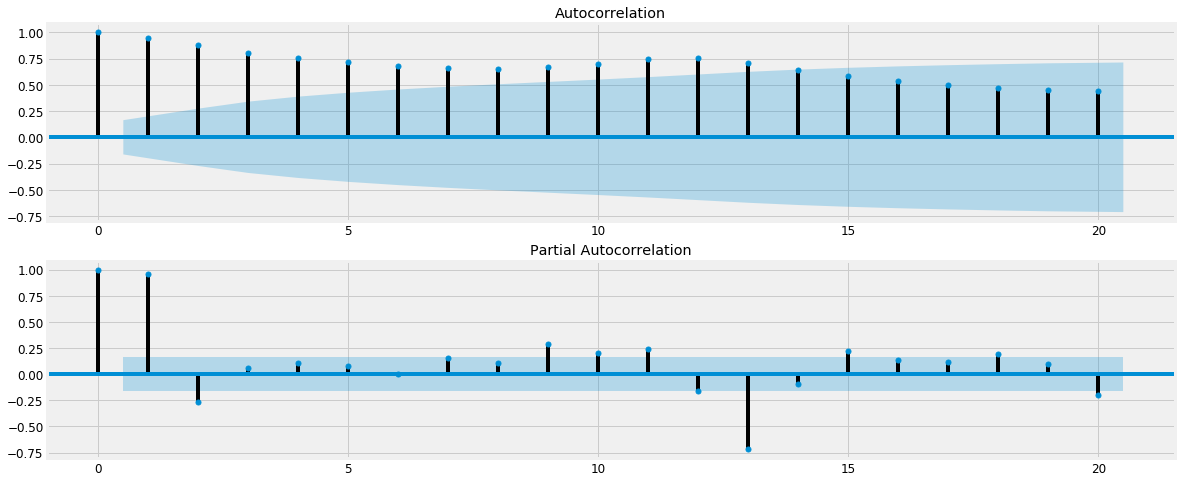

In [25]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

pyplot.figure()
pyplot.subplot(211)
plot_acf(y.passengers, ax=pyplot.gca(), lags = 20)
pyplot.subplot(212)
plot_pacf(y.passengers, ax=pyplot.gca(), lags = 20)
pyplot.show()

### Plotting Rolling Statistics
- We observe that the rolling mean and Standard deviation are not constant with respect to time (increasing trend)
- The time series is hence not stationary

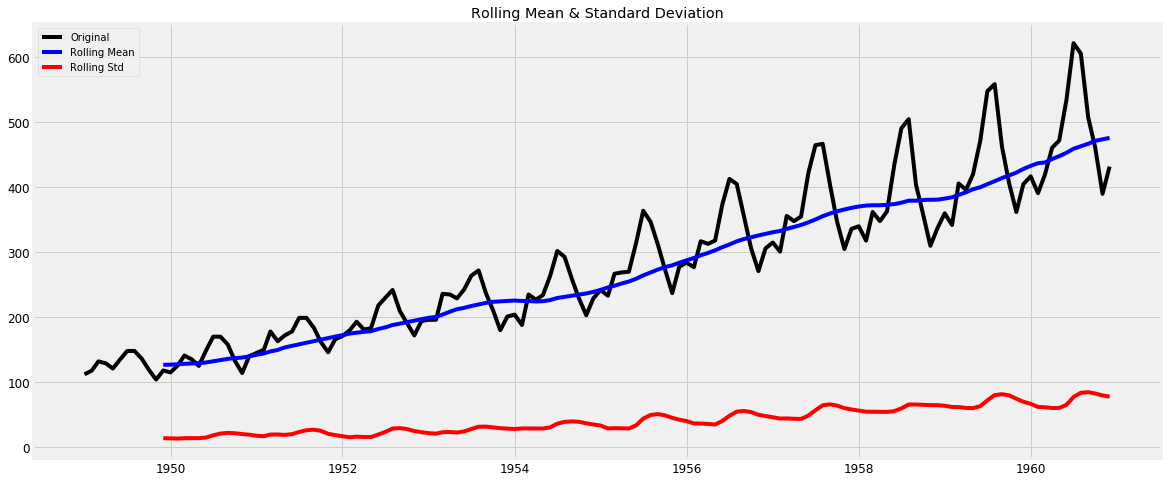

In [29]:
#rolling mean and rolling std
rolmean = y.rolling(12).mean()
rolstd = y.rolling(12).std()

#Plots of rolling:
orig = plt.plot(y, color='black',label='Original')
mean = plt.plot(rolmean, color='blue', label='Rolling Mean')
std = plt.plot(rolstd, color='red', label = 'Rolling Std')
plt.legend(loc='left')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)


### Augmented Dickey-Fuller Test
- The intuition behind the test is that if the series is integrated then the lagged level of the series y(t-1)  will provide no relevant information in predicting the change in y(t).
- Null hypothesis: The time series is not stationary
- Rejecting the null hypothesis (i.e. a very low p-value) will indicate staionarity

In [30]:
from statsmodels.tsa.stattools import adfuller

In [31]:
#Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(y.passengers, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [33]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd =timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='black',label='Original')
    mean = plt.plot(rolmean, color='blue', label='Rolling Mean')
    std = plt.plot(rolstd, color='red', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

## Making Time Series Stationary
There are 2 major reasons behind non-stationaruty of a TS:

1. __Trend__ – varying mean over time. For eg, in this case we saw that on average, the number of passengers was growing over time.
2. __Seasonality__ – variations at specific time-frames. eg people might have a tendency to buy cars in a particular month because of pay increment or festivals.

### Transformations
- We can apply transformation which penalize higher values more than smaller values. These can be taking a log, square root, cube root, etc. Lets take a log transform here for simplicity:

#### Log Scale Transformation

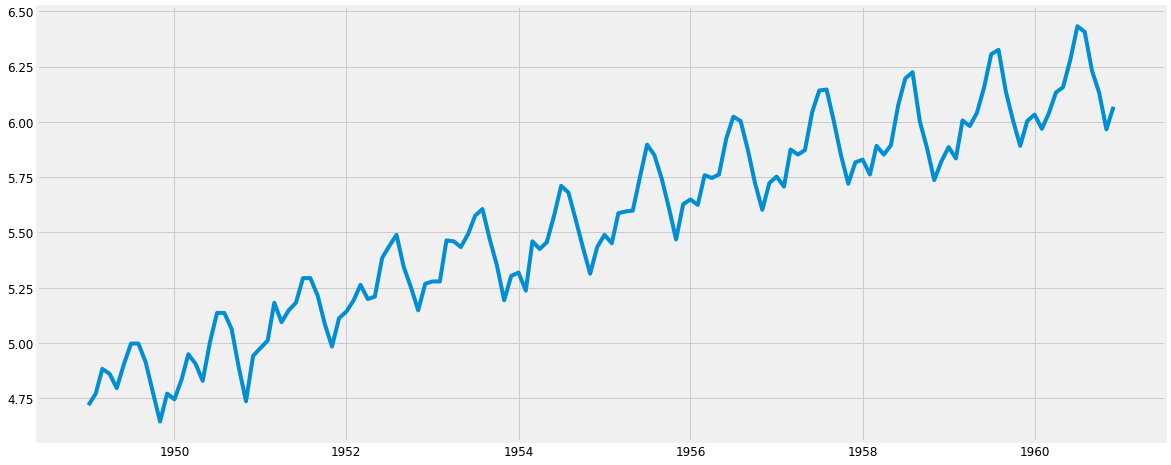

In [34]:
ts_log = np.log(y)
plt.plot(ts_log)

#### Other possible transformations:
- Exponential tranformation
- Box Cox transformation
- Square root transformation

### Techniques to remove Trend - Smoothing
- Smoothing is taking rolling averages over windows of time

#### Moving Average
- We take average of ‘k’ consecutive values depending on the frequency of time series. 
- Here we can take the average over the past 1 year, i.e. last 12 values. 
- A drawback in this particular approach is that the time-period has to be strictly defined. 

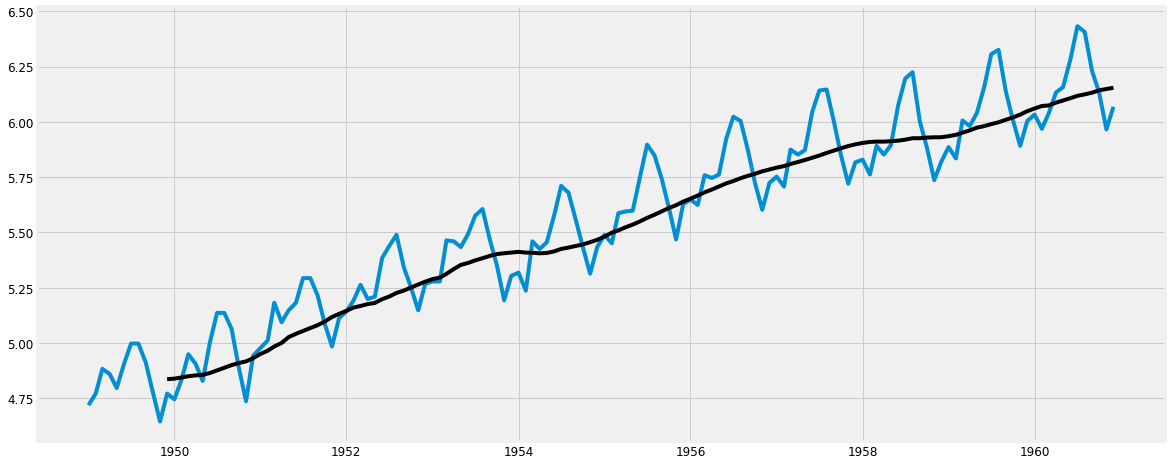

In [37]:
moving_avg = ts_log.rolling(12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='black')

In [38]:
ts_log_moving_avg_diff = ts_log.passengers - moving_avg.passengers
ts_log_moving_avg_diff.head(12)

year
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
Name: passengers, dtype: float64

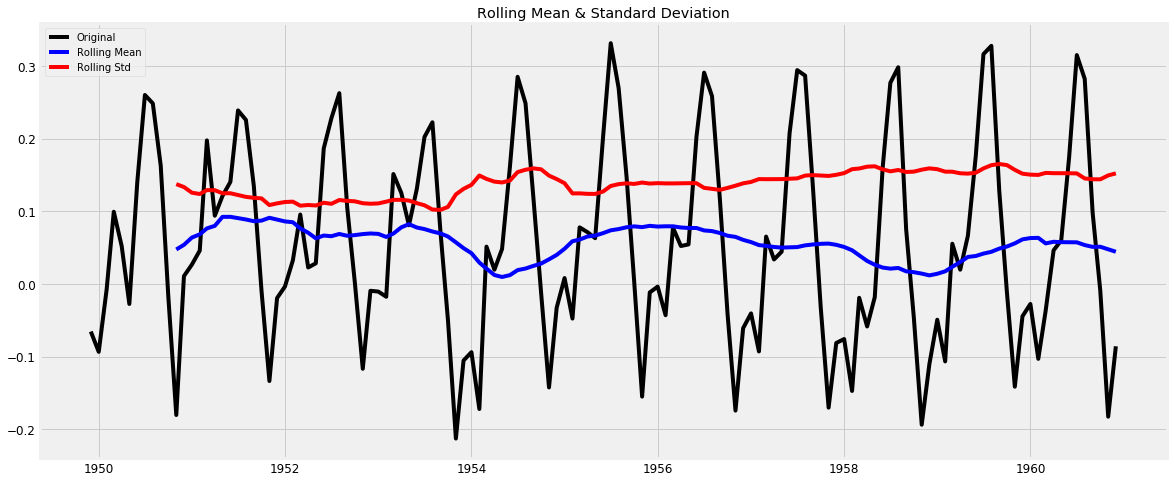

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [39]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

#### Exponentially weighted moving average:
- To overcome the problem of choosing a defined window in moving average, we can use exponential weighted moving average
- We take a ‘weighted moving average’ where more recent values are given a higher weight. 
- There can be many technique for assigning weights. A popular one is exponentially weighted moving average where weights are assigned to all the previous values with a decay factor. 

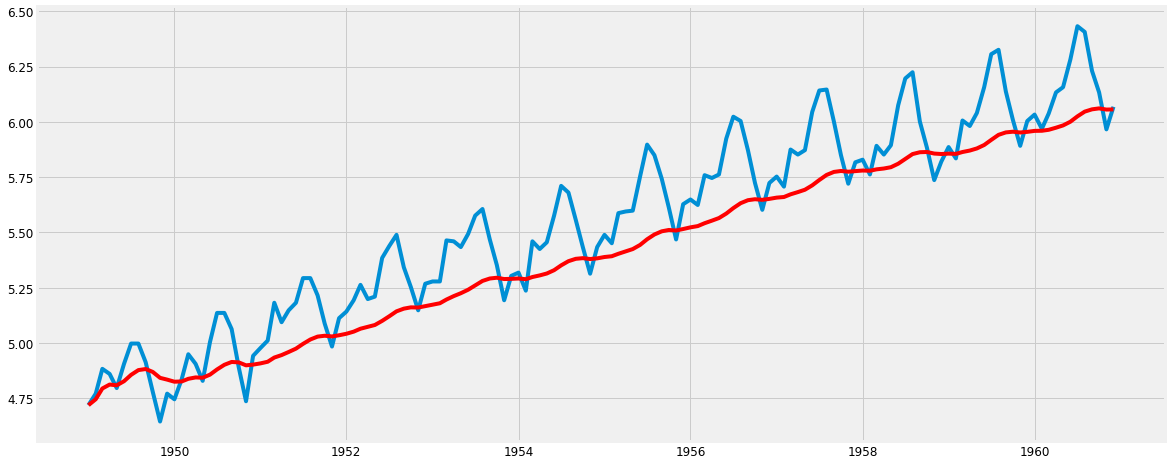

In [40]:
expwighted_avg = ts_log.ewm(halflife=12,min_periods=0,adjust=True,ignore_na=False).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')


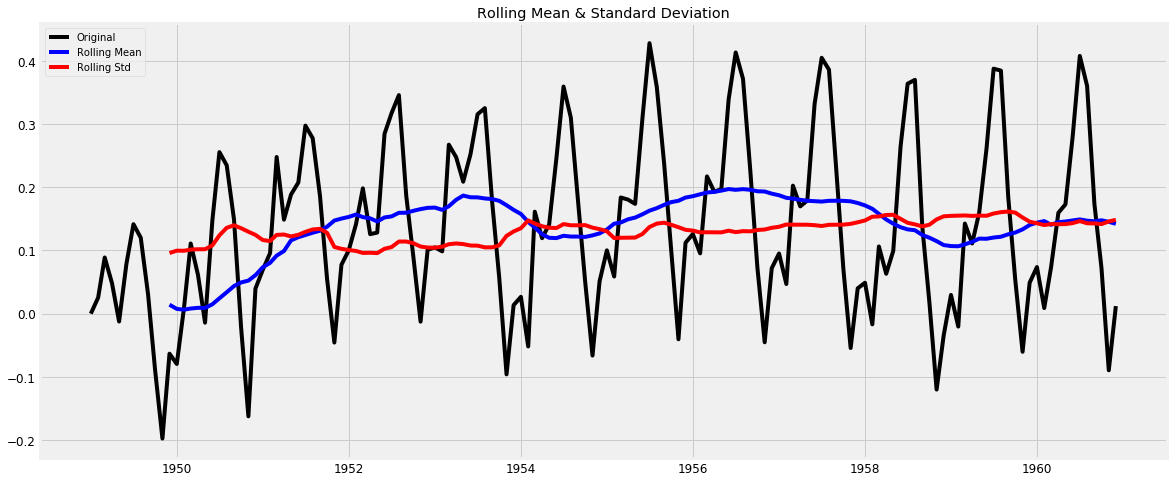

Results of Dickey-Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [41]:
ts_log_ewma_diff = ts_log.passengers - expwighted_avg.passengers
test_stationarity(ts_log_ewma_diff)

### Further Techniques to remove Seasonality and Trend
- The simple trend reduction techniques discussed before don’t work in all cases, particularly the ones with high seasonality. 

#### Differencing
- In this technique, we take the difference of the observation at a particular instant with that at the previous instant. 
- First order differencing in Pandas

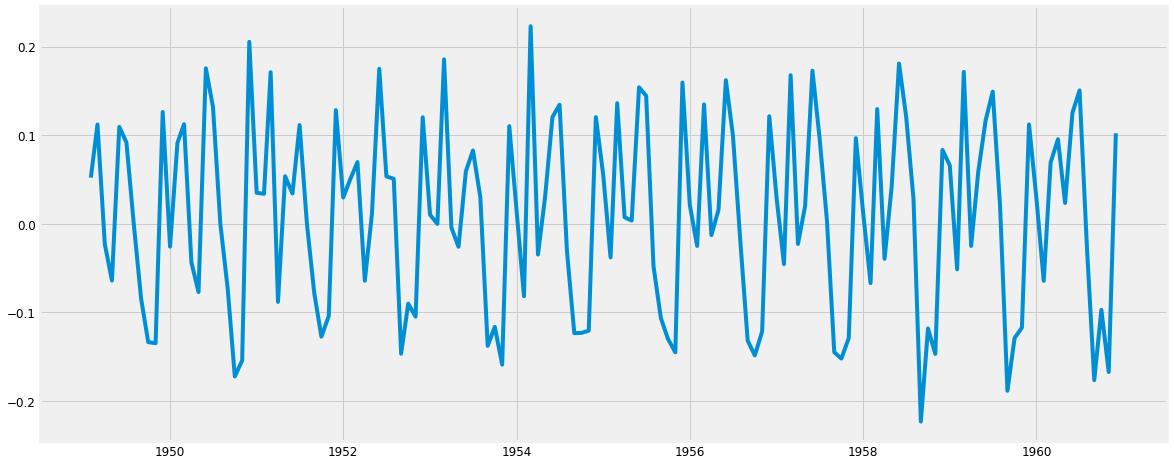

In [42]:
ts_log_diff = ts_log.passengers - ts_log.passengers.shift()
plt.plot(ts_log_diff)

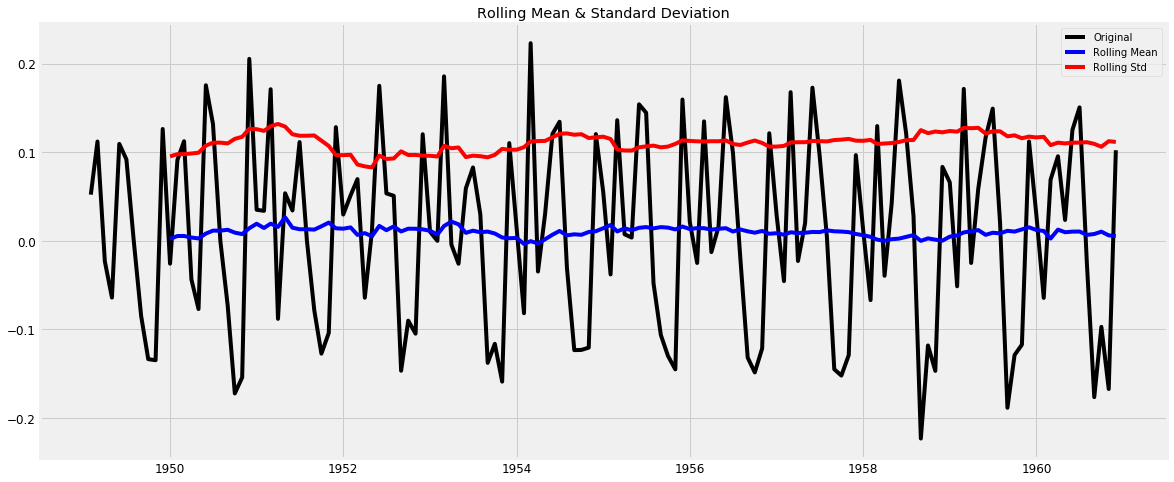

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [43]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

#### Decomposition
- In this approach, both trend and seasonality are modeled separately and the remaining part of the series is returned.

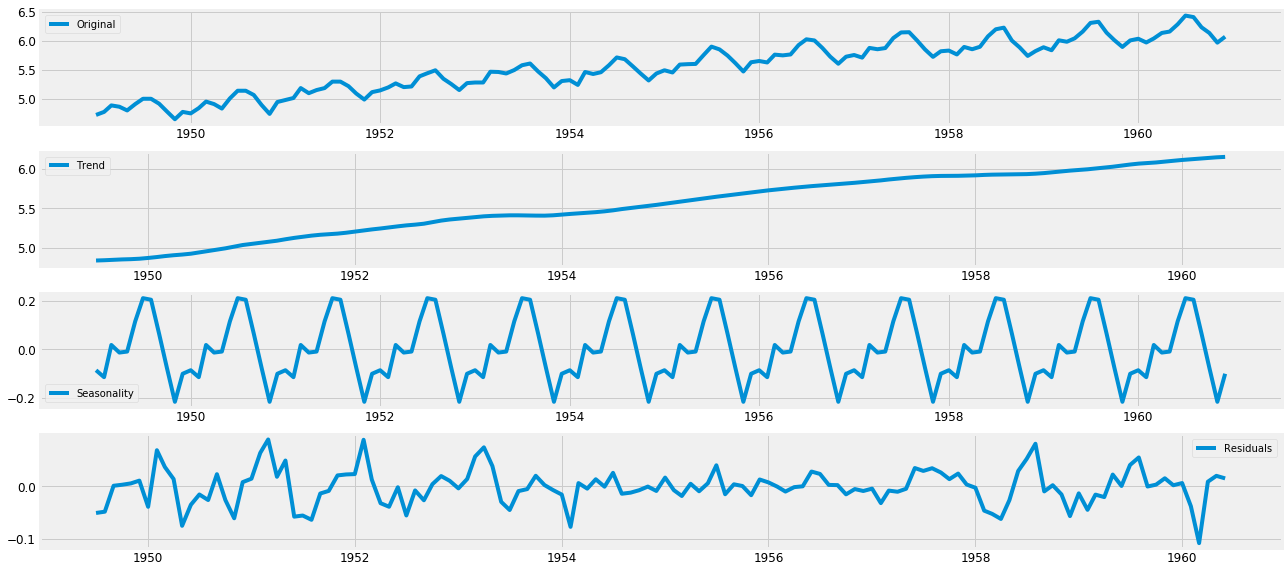

In [44]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# Time Series 

## Autoregression (AR)
- The autoregression (AR) method models the next step in the sequence as a linear function of the observations at prior time steps.
- __Number of AR (Auto-Regressive) terms (p):__ p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).

In [46]:
from statsmodels.tsa.ar_model import AR
from random import random

In [47]:
# fit model
model = AR(ts_log_diff)
model_fit = model.fit()

C:\Users\afrsa\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



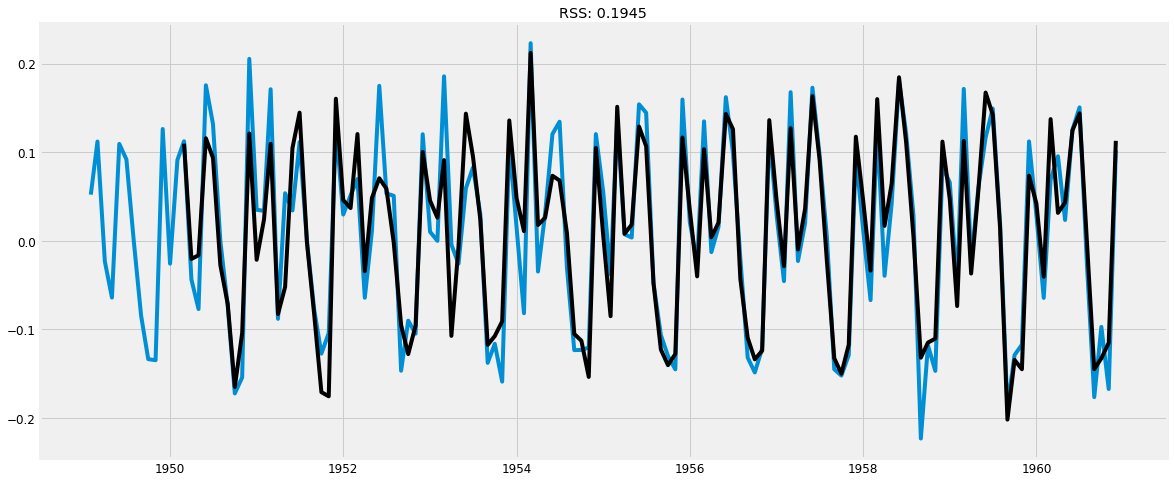

In [49]:
plt.plot(ts_log_diff)
plt.plot(model_fit.fittedvalues, color='black')
plt.title('RSS: %.4f'% np.nansum((model_fit.fittedvalues-ts_log_diff)**2))
plt.show()

### Reversing the transformations

__Fitted or predicted values:__

In [50]:
predictions_ARIMA_diff = pd.Series(model_fit.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())

year
1950-03-01    0.109713
1950-04-01   -0.020423
1950-05-01   -0.016243
1950-06-01    0.115842
1950-07-01    0.093564
dtype: float64


__Cumulative Sum to reverse differencing:__

In [51]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum.head())

year
1950-03-01    0.109713
1950-04-01    0.089291
1950-05-01    0.073048
1950-06-01    0.188891
1950-07-01    0.282455
dtype: float64


__Adding 1st month value which was previously removed while differencing:__

In [52]:
predictions_ARIMA_log = pd.Series(ts_log.passengers.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

year
1949-01-01    4.718499
1949-02-01    4.718499
1949-03-01    4.718499
1949-04-01    4.718499
1949-05-01    4.718499
dtype: float64

__Taking Exponent to reverse Log Transform:__

In [53]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)

Text(0.5, 1.0, 'RMSE: 78.5144')

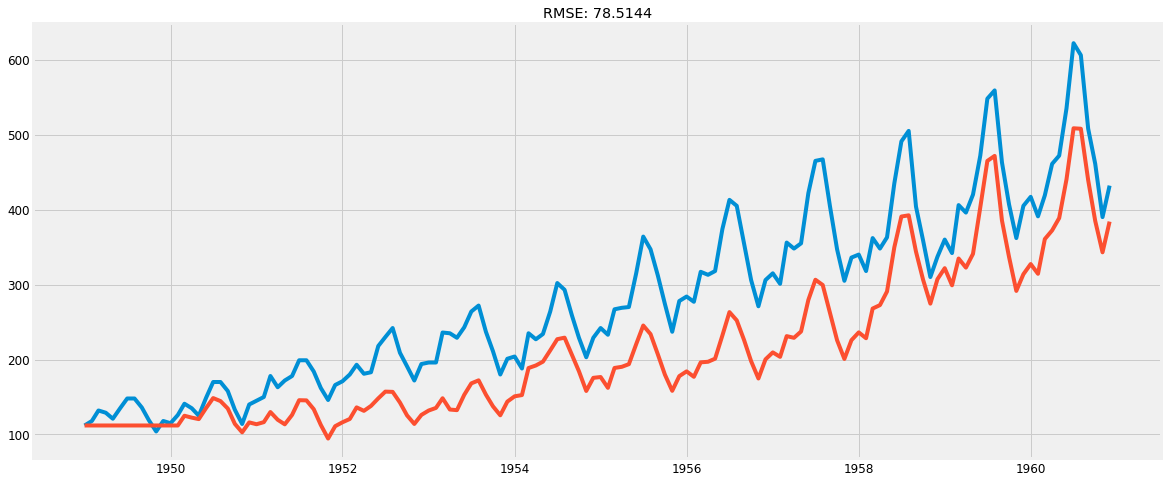

In [54]:
plt.plot(y.passengers)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(np.nansum((predictions_ARIMA-y.passengers)**2)/len(y.passengers)))

### Forecast quality scoring metrics
- __R squared__
- __Mean Absolute Error__
- __Median Absolute Error__
- __Mean Squared Error__
- __Mean Squared Logarithmic Error__
- __Mean Absolute Percentage Error__

In [55]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

__R squared__, coefficient of determination (it can be interpreted as a percentage of variance explained by the model), (-inf, 1] 
- sklearn.metrics.r2_score

In [56]:
r2_score(y.passengers, predictions_ARIMA)

0.5686734896130742

__Mean Absolute Error__, it is an interpretable metric because it has the same unit of measurement as the initial series, [0, +inf)
- sklearn.metrics.mean_absolute_error

In [57]:
mean_absolute_error(y.passengers, predictions_ARIMA)

69.42862838872749

__Median Absolute Error__, again an interpretable metric, particularly interesting because it is robust to outliers, [0, +inf)
- sklearn.metrics.median_absolute_error

In [58]:
median_absolute_error(y.passengers, predictions_ARIMA)

69.36695435384787

__Mean Squared Error__, most commonly used, gives higher penalty to big mistakes and vise versa, [0, +inf)
- sklearn.metrics.mean_squared_error


In [59]:
mean_squared_error(y.passengers, predictions_ARIMA)

6164.506983577632

__Mean Squared Logarithmic Error__, practically the same as MSE but we initially take logarithm of the series, as a result we give attention to small mistakes as well, usually is used when data has exponential trends, [0, +inf)
- sklearn.metrics.mean_squared_log_error

In [60]:
mean_squared_log_error(y.passengers, predictions_ARIMA)

0.09945599448249753

__Mean Absolute Percentage Error__, same as MAE but percentage, — very convenient when you want to explain the quality of the model to your management, [0, +inf), 
- not implemented in sklearn

In [61]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [62]:
mean_absolute_percentage_error(y.passengers, predictions_ARIMA)

24.47240542986235

__Function to evaluate forecast using above metrics:__

In [63]:
def evaluate_forecast(y,pred):
    results = pd.DataFrame({'r2_score':r2_score(y, pred),
                           }, index=[0])
    results['mean_absolute_error'] = mean_absolute_error(y, pred)
    results['median_absolute_error'] = median_absolute_error(y, pred)
    results['mse'] = mean_squared_error(y, pred)
    results['msle'] = mean_squared_log_error(y, pred)
    results['mape'] = mean_absolute_percentage_error(y, pred)
    results['rmse'] = np.sqrt(results['mse'])
    return results

In [64]:
evaluate_forecast(y.passengers, predictions_ARIMA)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.568673,69.428628,69.366954,6164.506984,0.099456,24.472405,78.514374


- RMSE has the benefit of penalizing large errors more so can be more appropriate in some cases, for example, if being off by 10 is more than twice as bad as being off by 5. But if being off by 10 is just twice as bad as being off by 5, then MAE is more appropriate.

- From an interpretation standpoint, MAE is clearly the winner. RMSE does not describe average error alone and has other implications that are more difficult to tease out and understand.

- On the other hand, one distinct advantage of RMSE over MAE is that RMSE avoids the use of taking the absolute value, which is undesirable in many mathematical calculations

## Moving Average (MA)

- __Number of MA (Moving Average) terms (q):__ q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value. 


In [65]:
# MA example
from statsmodels.tsa.arima_model import ARMA
from random import random

# fit model
model = ARMA(ts_log_diff, order=(0, 1))
model_fit = model.fit(disp=False)

C:\Users\afrsa\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



In [66]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             passengers   No. Observations:                  143
Model:                     ARMA(0, 1)   Log Likelihood                 121.754
Method:                       css-mle   S.D. of innovations              0.103
Date:                Fri, 21 Feb 2020   AIC                           -237.507
Time:                        12:29:36   BIC                           -228.619
Sample:                    02-01-1949   HQIC                          -233.895
                         - 12-01-1960                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0097      0.011      0.887      0.375      -0.012       0.031
ma.L1.passengers     0.2722      0.095      2.873      0.004       0.086       0.458
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -3.6744           +0.0000j            3.6744            0.5000
-----------------------------------------------------------------------------
"""

Text(0.5, 1.0, 'RSS: 1.5245')

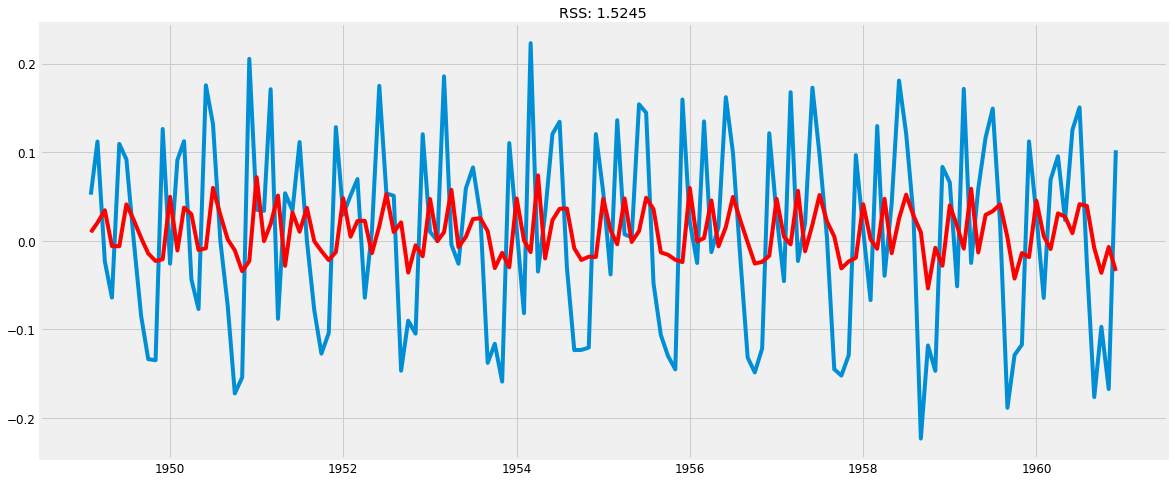

In [67]:
plt.plot(ts_log_diff)
plt.plot(model_fit.fittedvalues, color='red')
plt.title('RSS: %.4f'% np.nansum((model_fit.fittedvalues-ts_log_diff)**2))

## Autoregressive Moving Average (ARMA)

- __Number of AR (Auto-Regressive) terms (p):__ p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
- __Number of MA (Moving Average) terms (q):__ q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value. 


In [68]:
# ARMA example
from statsmodels.tsa.arima_model import ARMA
from random import random

# fit model
model = ARMA(ts_log_diff, order=(2, 1))
model_fit = model.fit(disp=False)

C:\Users\afrsa\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



In [69]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             passengers   No. Observations:                  143
Model:                     ARMA(2, 1)   Log Likelihood                 140.076
Method:                       css-mle   S.D. of innovations              0.090
Date:                Fri, 21 Feb 2020   AIC                           -270.151
Time:                        12:29:39   BIC                           -255.337
Sample:                    02-01-1949   HQIC                          -264.131
                         - 12-01-1960                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0101      0.000     23.505      0.000       0.009       0.011
ar.L1.passengers     0.9983      0.076     13.163      0.000       0.850       1.147
ar.L2.passengers    -0.4134      0.077     -5.384      0.000      -0.564      -0.263
ma.L1.passengers    -0.9999      0.028    -35.282      0.000      -1.055      -0.944
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2073           -0.9804j            1.5552           -0.1085
AR.2            1.2073           +0.9804j            1.5552            0.1085
MA.1            1.0001           +0.0000j            1.0001            0.0000
-----------------------------------------------------------------------------
"""

Text(0.5, 1.0, 'RSS: 1.1753')

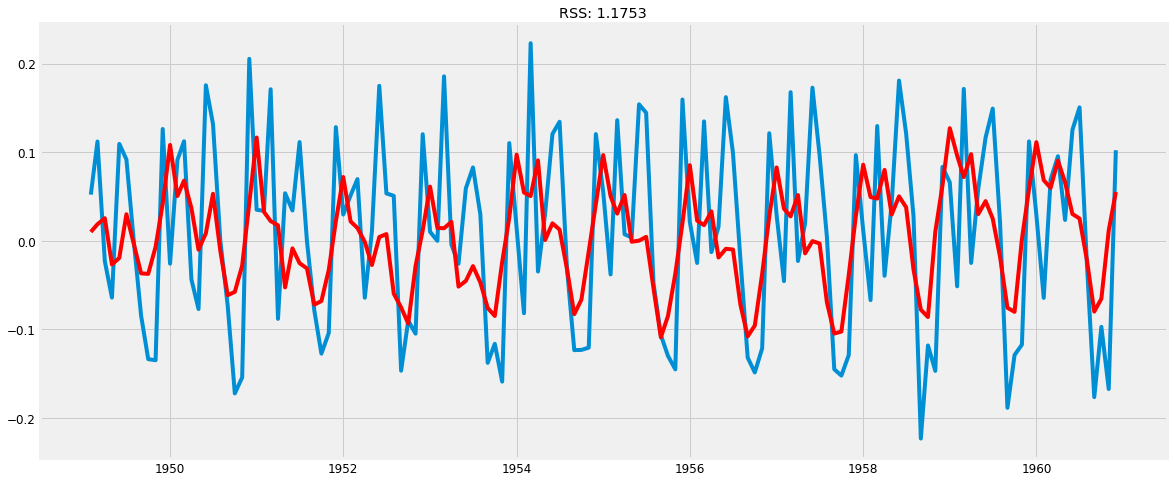

In [70]:
plt.plot(ts_log_diff)
plt.plot(model_fit.fittedvalues, color='red')
plt.title('RSS: %.4f'% np.nansum((model_fit.fittedvalues-ts_log_diff)**2))

## Autoregressive Integrated Moving Average (ARIMA)
In an ARIMA model there are 3 parameters that are used to help model the major aspects of a times series: seasonality, trend, and noise. These parameters are labeled p,d,and q.

- __Number of AR (Auto-Regressive) terms (p):__ p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
- __Number of Differences (d):__ d is the parameter associated with the integrated part of the model, which effects the amount of differencing to apply to a time series.
- __Number of MA (Moving Average) terms (q):__ q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value. 

<br>__Observations from EDA on the time series:__
- Non stationarity implies at least one level of differencing (d) is required in ARIMA
- [The next step is to select the lag values for the Autoregression (AR) and Moving Average (MA) parameters, p and q respectively, using PACF, ACF plots](https://people.duke.edu/~rnau/411arim3.htm)

[Tuning ARIMA parameters](https://machinelearningmastery.com/tune-arima-parameters-python/)


Note: A problem with ARIMA is that it does not support seasonal data. That is a time series with a repeating cycle. ARIMA expects data that is either not seasonal or has the seasonal component removed, e.g. seasonally adjusted via methods such as seasonal differencing.

In [71]:
ts = y.passengers - y.passengers.shift()
ts.dropna(inplace=True)

__ACF and PACF plots after differencing:__
- Confidence intervals are drawn as a cone. 
- By default, this is set to a 95% confidence interval, suggesting that correlation values outside of this code are very likely a correlation and not a statistical fluke.
- AR(1) process -- has ACF tailing out and PACF cutting off at lag=1
- AR(2) process -- has ACF tailing out and PACF cutting off at lag=2
- MA(1) process -- has ACF cut off at lag=1
- MA(2) process -- has ACF cut off at lag=2

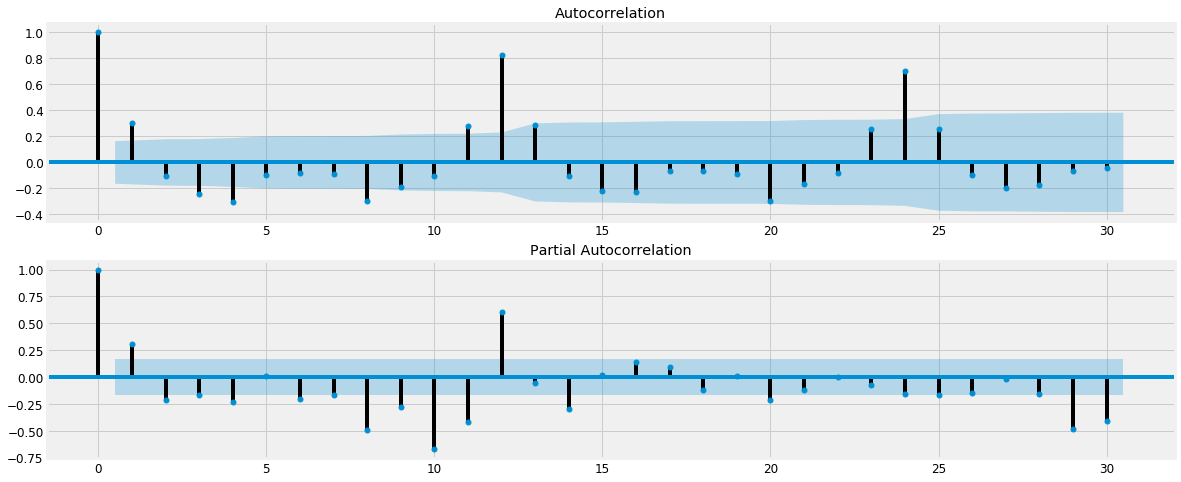

In [72]:
pyplot.figure()
pyplot.subplot(211)
plot_acf(ts, ax=pyplot.gca(),lags=30)
pyplot.subplot(212)
plot_pacf(ts, ax=pyplot.gca(),lags=30)
pyplot.show()

## Interpreting ACF plots


ACF Shape	| Indicated Model |
-- | -- |
Exponential, decaying to zero |	Autoregressive model. Use the partial autocorrelation plot to identify the order of the autoregressive model |
Alternating positive and negative, decaying to zero	Autoregressive model. |  Use the partial autocorrelation plot to help identify the order. |
One or more spikes, rest are essentially zero | Moving average model, order identified by where plot becomes zero. |
Decay, starting after a few lags |	Mixed autoregressive and moving average (ARMA) model. | 
All zero or close to zero | Data are essentially random. |
High values at fixed intervals | Include seasonal autoregressive term. |
No decay to zero |	Series is not stationary |

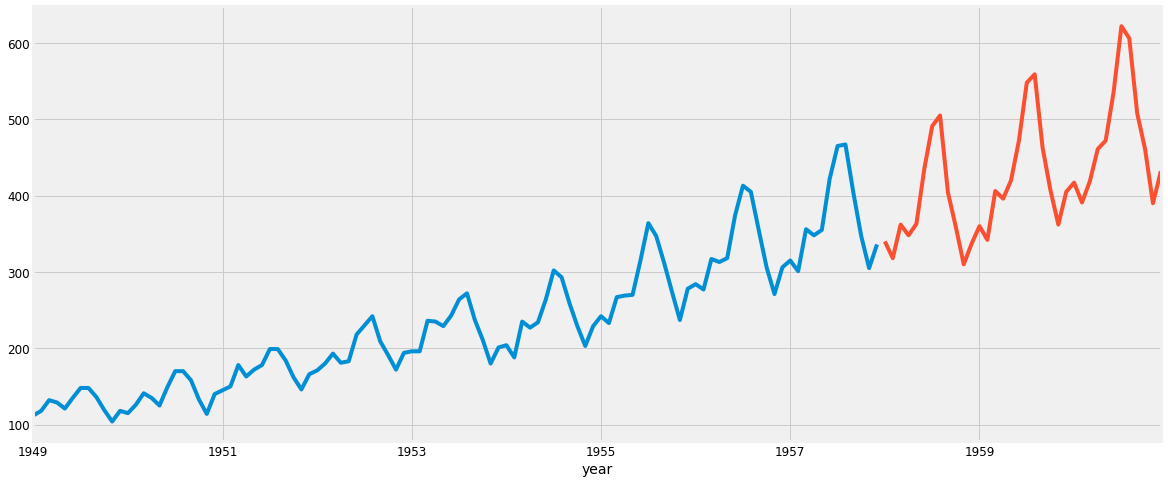

In [73]:
#divide into train and validation set
train = y[:int(0.75*(len(y)))]
valid = y[int(0.75*(len(y))):]

#plotting the data
train['passengers'].plot()
valid['passengers'].plot()

In [74]:
# ARIMA example
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# fit model
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit(disp=1)

C:\Users\afrsa\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\afrsa\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



In [75]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D.passengers   No. Observations:                  107
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -493.230
Method:                       css-mle   S.D. of innovations             23.986
Date:                Fri, 21 Feb 2020   AIC                            994.461
Time:                        12:29:44   BIC                           1005.152
Sample:                    02-01-1949   HQIC                           998.795
                         - 12-01-1957                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.4356      0.265      9.186      0.000       1.916       2.955
ar.L1.D.passengers     0.7409      0.067     10.991      0.000       0.609       0.873
ma.L1.D.passengers    -1.0000      0.025    -39.435      0.000      -1.050      -0.950
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3496           +0.0000j            1.3496            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [76]:
start_index = valid.index.min()
end_index = valid.index.max()

#Predictions
predictions = model_fit.predict(start=start_index, end=end_index)

In [77]:
# report performance
mse = mean_squared_error(y[start_index:end_index], predictions)
rmse = sqrt(mse)
print('RMSE: {}, MSE:{}'.format(rmse,mse))

RMSE: 432.6263808943154, MSE:187165.58544571325


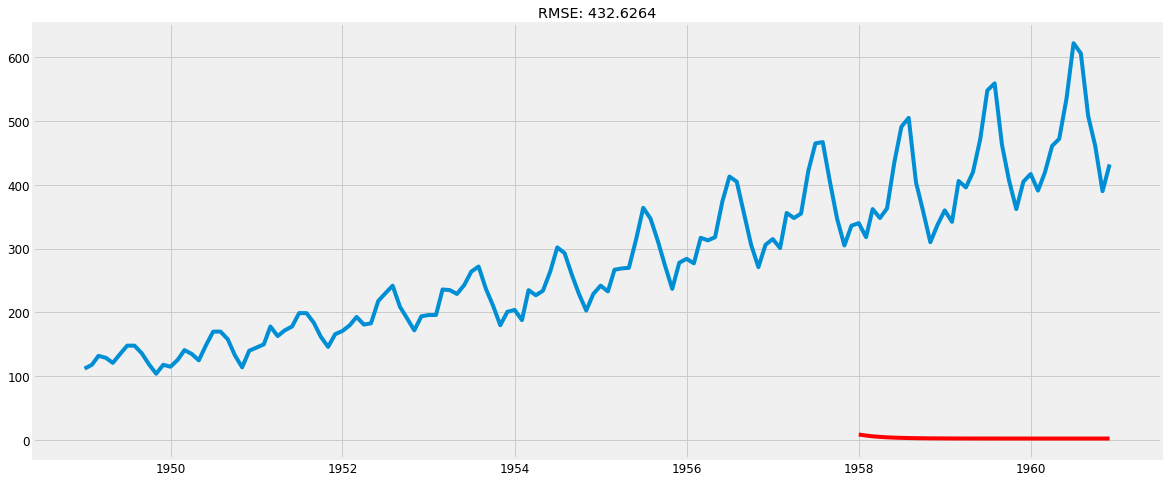

In [78]:
plt.plot(y.passengers)
plt.plot(predictions, color='red')
plt.title('RMSE: %.4f'% rmse)
plt.show()

__Fitted or predicted values:__

In [79]:
predictions_ARIMA_diff = pd.Series(predictions, copy=True)
print (predictions_ARIMA_diff.head())

1958-01-01    8.743424
1958-02-01    7.109318
1958-03-01    5.898541
1958-04-01    5.001426
1958-05-01    4.336716
Freq: MS, dtype: float64


__Cumulative Sum to reverse differencing:__

In [80]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum.head())

1958-01-01     8.743424
1958-02-01    15.852742
1958-03-01    21.751283
1958-04-01    26.752709
1958-05-01    31.089425
Freq: MS, dtype: float64


__Adding 1st month value which was previously removed while differencing:__

In [81]:
predictions_ARIMA_log = pd.Series(valid.passengers.iloc[0], index=valid.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

year
1958-01-01    348.743424
1958-02-01    355.852742
1958-03-01    361.751283
1958-04-01    366.752709
1958-05-01    371.089425
dtype: float64

__Taking Exponent to reverse Log Transform:__

Text(0.5, 1.0, 'RMSE: 205.2935')

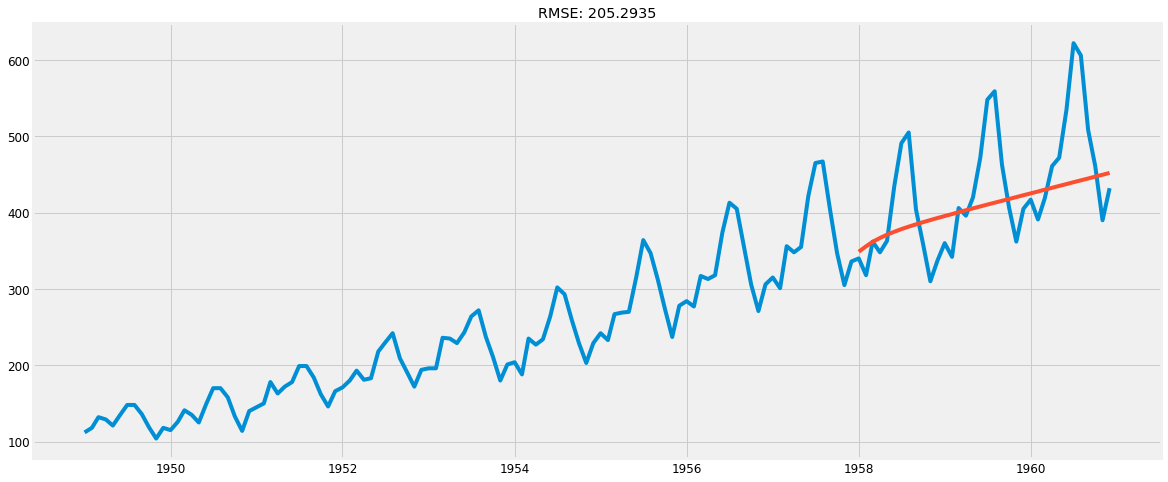

In [82]:
plt.plot(y.passengers)
plt.plot(predictions_ARIMA_log)
plt.title('RMSE: %.4f'% np.sqrt(np.nansum((predictions_ARIMA_log-ts)**2)/len(ts)))

In [83]:
evaluate_forecast(y[start_index:end_index], predictions_ARIMA_log)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.179865,52.106957,36.843692,5017.837994,0.023691,NaN,70.836699


### Auto ARIMA

In [84]:
#building the model
from pmdarima.arima import auto_arima
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)

Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=959.218, BIC=975.255, Time=0.254 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=1002.826, BIC=1008.172, Time=0.005 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=996.373, BIC=1004.392, Time=0.024 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=991.646, BIC=999.664, Time=0.049 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=1001.531, BIC=1004.204, Time=0.007 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=971.486, BIC=984.850, Time=0.213 seconds
Near non-invertible roots for order (1, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=969.040, BIC=982.405, Time=0.187 seconds
Near non-invertible roots for order (2, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to t

ARIMA(maxiter=50, method='lbfgs', order=(3, 1, 3), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

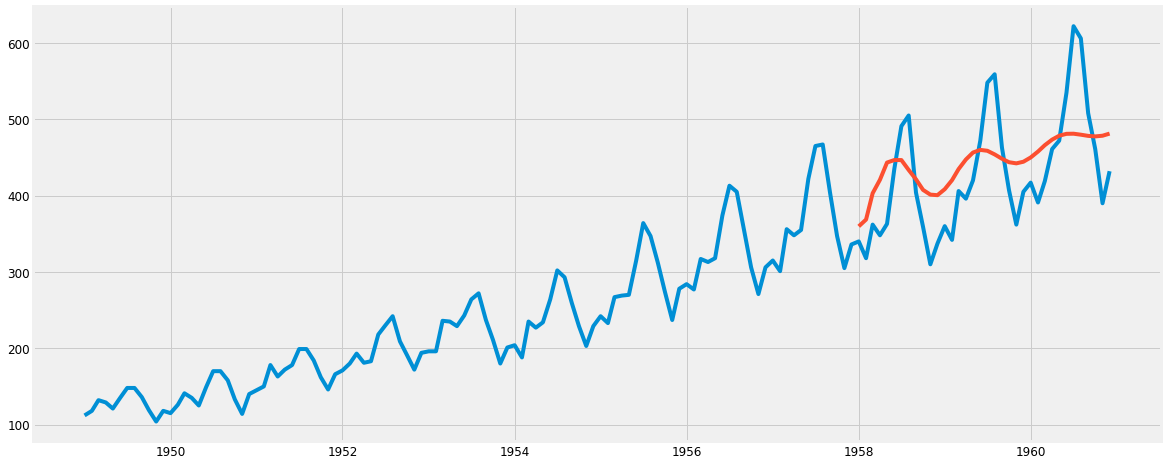

In [85]:
forecast = model.predict(n_periods=len(valid))
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

#plot the predictions for validation set
plt.plot(y.passengers, label='Train')
#plt.plot(valid, label='Valid')
plt.plot(forecast, label='Prediction')
plt.show()

In [86]:
evaluate_forecast(valid, forecast)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.370489,52.89917,48.443948,3851.54092,0.019646,NaN,62.060784


## Seasonal Autoregressive Integrated Moving-Average (SARIMA)
Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component.

It adds three new hyperparameters to specify the autoregression (AR), differencing (I) and moving average (MA) for the seasonal component of the series, as well as an additional parameter for the period of the seasonality.

__Trend Elements:__

There are three trend elements that require configuration. They are the same as the ARIMA model, specifically:

- p: Trend autoregression order.
- d: Trend difference order.
- q: Trend moving average order.

__Seasonal Elements:__

There are four seasonal elements that are not part of ARIMA that must be configured; they are:

- P: Seasonal autoregressive order.
- D: Seasonal difference order.
- Q: Seasonal moving average order.
- m: The number of time steps for a single seasonal period. For example, an S of 12 for monthly data suggests a yearly seasonal cycle.

__SARIMA notation:__
SARIMA(p,d,q)(P,D,Q,m)

In [87]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import warnings
from pylab import rcParams
#from ljungbox import *

In [88]:
warnings.filterwarnings('ignore')
%matplotlib inline
rcParams['figure.figsize'] = 18, 6
y = pd.DataFrame.from_records(sm.datasets.co2.load().data)
y['index']
y['year'] = pd.to_datetime(y['index'], format='%Y%m%d')
y = y.set_index('year')

In [89]:
# Weekly data can be tricky to work with since it’s a briefer amount of time, 
# so let's use monthly averages instead.
# The 'MS' string groups the data in buckets by start of the month
y = y['co2'].resample('MS').mean()
# The term bfill means that we use the value before filling in missing values
y = y.fillna(y.bfill())
y.head()

year
1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01    315.625000
1958-07-01    315.625000
Freq: MS, Name: co2, dtype: float64

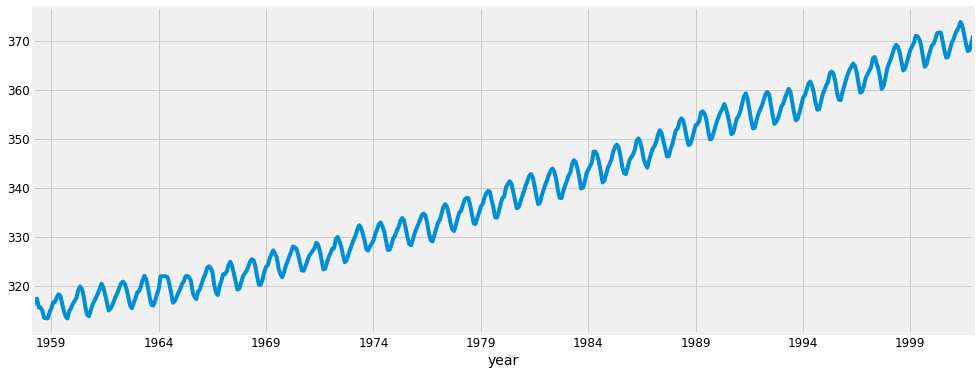

In [90]:
#time series e as a data visualization
y.plot(figsize=(15, 6))
plt.show()

# select the optimal parameter values for our ARIMA(p,d,q)(P,D,Q)s time series model.

We will use a "grid search" to iteratively explore different combinations of parameters. For each combination of parameters, we fit a new seasonal ARIMA model with the SARIMAX() function from the statsmodels module and assess its overall quality. Once we have explored the entire landscape of parameters, our optimal set of parameters will be the one that yields the best performance for our criteria of interest.

In [91]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


The code chunk below iterates through combinations of parameters and uses the SARIMAX function from statsmodels to fit the corresponding Seasonal ARIMA model. Here, the order argument specifies the (p, d, q) parameters, while the seasonal_order argument specifies the (P, D, Q, S) seasonal component of the Seasonal ARIMA model. After fitting each SARIMAX()model, the code prints out its respective AIC score.
When evaluating and comparing statistical models fitted with different parameters, each can be ranked against one another based on how well it fits the data or its ability to accurately predict future data points. 
AIC (Akaike Information Criterion) value, which is conveniently returned with ARIMA models fitted using statsmodels. The AIC measures how well a model fits the data while taking into account the overall complexity of the model. A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest AIC value.

In [94]:
AIC = []
parm_ = []
parm_s = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            AIC.append(results.aic)
            parm_.append(param)
            parm_s.append(param_seasonal)

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:7612.583429881011
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:6787.343623902172
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1854.828234141261
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1596.711172764134
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1058.9388921320021
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1056.2878539625997
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1361.6578977746117
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1044.764791265367
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:6881.048754479638
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:6072.662327392327
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1379.1941066995387
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1241.4174716814193
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1087.1396972557027
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:780.4315986003464
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1119.5957893630605
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:807.0912988957436
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1675.8086923024293
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1240.2211199194094
A

In [95]:
min(AIC)

277.78022304683003

In [96]:
pos = AIC.index(min(AIC))

In [97]:
parm_[pos]

(1, 1, 1)

In [98]:
parm_s[pos]

(1, 1, 1, 12)


The output of our code suggests that SARIMAX(1, 1, 1)x(1, 1, 1, 12) yields the lowest AIC value of 277.78. We should therefore consider this to be optimal option out of all the models we have considered.

# Fitting an ARIMA Time Series Model


In [99]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=parm_[pos],
                                seasonal_order=parm_s[pos],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3181      0.092      3.441      0.001       0.137       0.499
ma.L1         -0.6254      0.077     -8.162      0.000      -0.776      -0.475
ar.S.L12       0.0010      0.001      1.732      0.083      -0.000       0.002
ma.S.L12      -0.8769      0.026    -33.808      0.000      -0.928      -0.826
sigma2         0.0972      0.004     22.632      0.000       0.089       0.106


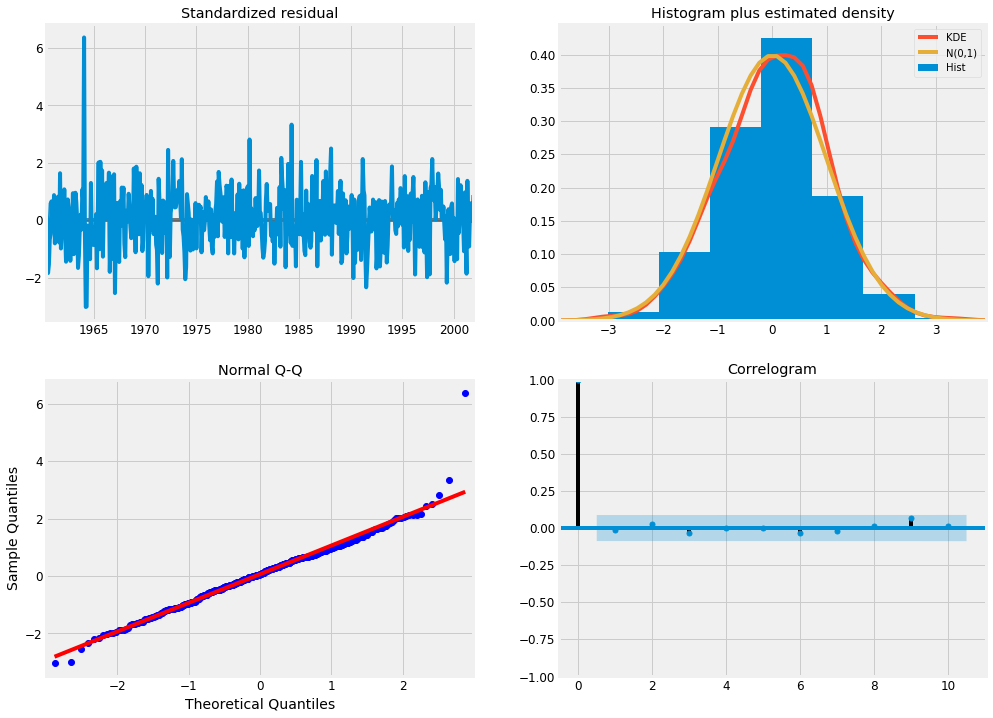

In [100]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [101]:
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                co2   No. Observations:                  526
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -133.890
Date:                            Fri, 21 Feb 2020   AIC                            277.780
Time:                                    12:31:14   BIC                            298.843
Sample:                                03-01-1958   HQIC                           286.046
                                     - 12-01-2001                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3181      0.092      3.441      0.001       0.137       0.499
ma.L1         -0.6254      0.077   


The summary attribute that results from the output of SARIMAX returns a significant amount of information, but we'll focus our attention on the table of coefficients. 
The coef column shows the weight (i.e. importance) of each feature and how each one impacts the time series. 
The P>|z| column informs us of the significance of each feature weight. 
Here, each weight has a p-value lower or close to 0.05, so it is reasonable to retain all of them in our model.


# Validating Forecasts

We have obtained a model for our time series that can now be used to produce forecasts. We start by comparing predicted values to real values of the time series, which will help us understand the accuracy of our forecasts. The get_prediction() and conf_int() attributes allow us to obtain the values and associated confidence intervals for forecasts of the time series.

In [102]:
pred = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=False)
pred_ci = pred.conf_int()
y[y.index >= '1998-01-01'].head()

year
1998-01-01    365.340
1998-02-01    366.200
1998-03-01    367.375
1998-04-01    368.525
1998-05-01    369.140
Freq: MS, Name: co2, dtype: float64

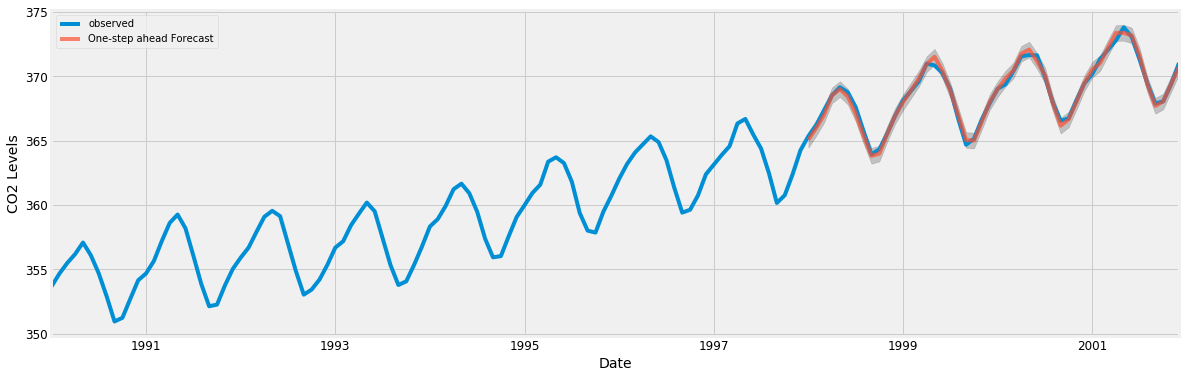

In [103]:
ax = y['1990':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()
plt.show()

In [104]:
y_forecasted = pred.predicted_mean
y_truth = y['1998-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.07


### Auto - SARIMA
Understand p, d, and q
ARIMA models are made up of three different terms:
p
p
: The order of the auto-regressive (AR) model (i.e., the number of lag observations). A time series is considered AR when previous values in the time series are very predictive of later values. An AR process will show a very gradual decrease in the ACF plot.
d
d
: The degree of differencing.
q
q
: The order of the moving average (MA) model. This is essentially the size of the “window” function over your time series data. An MA process is a linear combination of past errors.

In [107]:
#building the model
from pmdarima import auto_arima
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True, seasonal=True, m=6, stepwise=True)
model.fit(train)

Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(1, 0, 1, 6) (constant=True); AIC=936.762, BIC=958.144, Time=0.537 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 6) (constant=True); AIC=1002.826, BIC=1008.172, Time=0.078 seconds
Fit ARIMA: (1, 1, 0)x(1, 0, 0, 6) (constant=True); AIC=997.166, BIC=1007.858, Time=0.104 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 1, 6) (constant=True); AIC=993.576, BIC=1004.268, Time=0.118 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 6) (constant=False); AIC=1001.531, BIC=1004.204, Time=0.006 seconds
Fit ARIMA: (2, 1, 2)x(0, 0, 1, 6) (constant=True); AIC=956.753, BIC=975.463, Time=0.506 seconds
Fit ARIMA: (2, 1, 2)x(1, 0, 0, 6) (constant=True); AIC=974.518, BIC=993.227, Time=0.453 seconds
Near non-invertible roots for order (2, 1, 2)(1, 0, 0, 6); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIMA: (2, 1, 2)x(2, 0, 1, 6) (constant=True); AIC=827.774, BIC=851.830, Time=0.913 seconds
Near non-invertible root

ARIMA(maxiter=50, method='lbfgs', order=(2, 1, 2), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(2, 0, 1, 6),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [108]:
start_index = valid.index.min()
end_index = valid.index.max()

#Predictions
pred = model.predict()

In [109]:
pred = model.predict(n_periods=len(valid))
pred = pd.DataFrame(pred,index = valid.index,columns=['Prediction'])

### Tuned SARIMA

In [111]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 6) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 6)
SARIMAX: (0, 0, 1) x (0, 1, 0, 6)
SARIMAX: (0, 1, 0) x (0, 1, 1, 6)
SARIMAX: (0, 1, 0) x (1, 0, 0, 6)


In [112]:
min_aic = 999999999
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            #Check for best model with lowest AIC
            if results.aic < min_aic:
                min_aic = results.aic
                min_aic_model = results
        except:
            continue


ARIMA(0, 0, 0)x(0, 0, 0, 6)12 - AIC:1484.6772209911371
ARIMA(0, 0, 0)x(0, 0, 1, 6)12 - AIC:1332.7081717070832
ARIMA(0, 0, 0)x(0, 1, 0, 6)12 - AIC:1106.9983169558561
ARIMA(0, 0, 0)x(0, 1, 1, 6)12 - AIC:1015.267707006778
ARIMA(0, 0, 0)x(1, 0, 0, 6)12 - AIC:1115.9461051704866
ARIMA(0, 0, 0)x(1, 0, 1, 6)12 - AIC:1001.475594644543
ARIMA(0, 0, 0)x(1, 1, 0, 6)12 - AIC:951.0958895418041
ARIMA(0, 0, 0)x(1, 1, 1, 6)12 - AIC:860.2555893602176
ARIMA(0, 0, 1)x(0, 0, 0, 6)12 - AIC:1334.2309362006279
ARIMA(0, 0, 1)x(0, 0, 1, 6)12 - AIC:1194.1257357113373
ARIMA(0, 0, 1)x(0, 1, 0, 6)12 - AIC:998.4912121256897
ARIMA(0, 0, 1)x(0, 1, 1, 6)12 - AIC:912.8780689458828
ARIMA(0, 0, 1)x(1, 0, 0, 6)12 - AIC:1018.9733569616249
ARIMA(0, 0, 1)x(1, 0, 1, 6)12 - AIC:914.9884746690549
ARIMA(0, 0, 1)x(1, 1, 0, 6)12 - AIC:866.3727396781682
ARIMA(0, 0, 1)x(1, 1, 1, 6)12 - AIC:792.5520247092577
ARIMA(0, 1, 0)x(0, 0, 0, 6)12 - AIC:993.1312724630138
ARIMA(0, 1, 0)x(0, 0, 1, 6)12 - AIC:943.9245123025036
ARIMA(0, 1, 0)x(0, 1,

In [113]:
min_aic_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                        passengers   No. Observations:                  108
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 6)   Log Likelihood                -337.236
Date:                           Fri, 21 Feb 2020   AIC                            682.471
Time:                                   12:33:40   BIC                            692.602
Sample:                               01-01-1949   HQIC                           686.562
                                    - 12-01-1957                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4552      0.082     -5.543      0.000      -0.616      -0.294
ar.S.L6       -1.0894      0.017    -65.220      0.000      -1.122      -1.057
ma.S.L6        2.2734      0.600      3.792      0.000       1.098       3.449
sigma2        15.8288      7.949      1.991      0.046       0.249      31.408
===================================================================================
Ljung-Box (Q):                       45.44   Jarque-Bera (JB):                 2.17
Prob(Q):                              0.26   Prob(JB):                         0.34
Heteroskedasticity (H):               0.61   Skew:                             0.37
Prob(H) (two-sided):                  0.17   Kurtosis:                         2.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [114]:
start_index = valid.index.min()
end_index = valid.index.max()

#Predictions
pred = min_aic_model.get_prediction(start=start_index,end=end_index, dynamic=False)

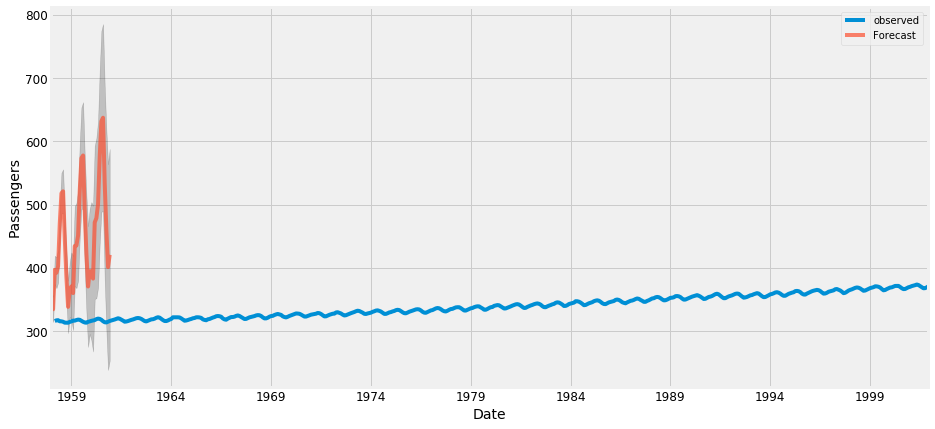

In [115]:
pred_ci = pred.conf_int()
ax = y['1949':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Passengers')
plt.legend()
plt.show()

__Model diagnostics:__
- Our primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. 
- If the seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved.

The model diagnostic suggests that the model residual is normally distributed based on the following:

- In the top right plot, the red KDE line follows closely with the N(0,1) line. Where, N(0,1) is the standard notation for a normal distribution with mean 0 and standard deviation of 1. This is a good indication that the residuals are normally distributed. 
- The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution. Again, this is a strong indication that the residuals are normally distributed.
- The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. 
- This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

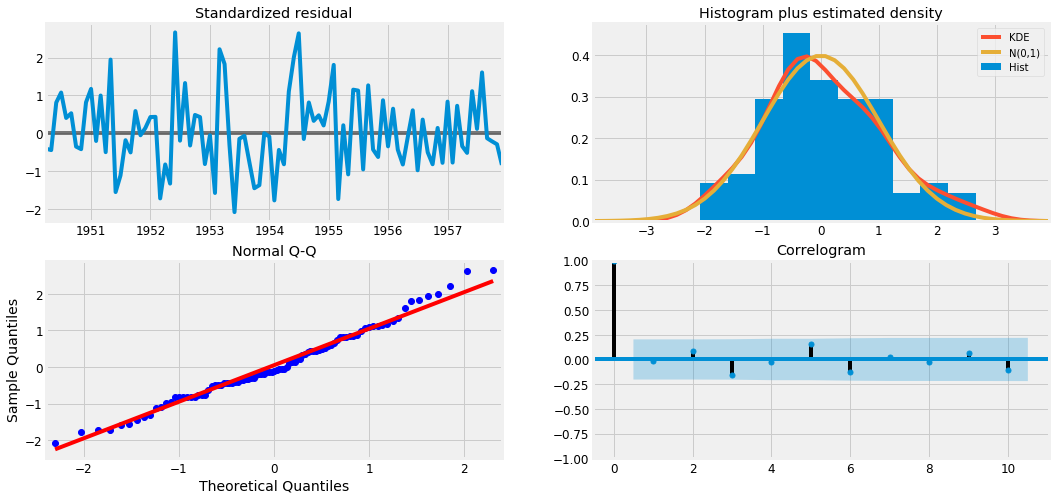

In [116]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [119]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 0.27


## Prophet
- [Prophet](https://facebook.github.io/prophet/) is open source software released by Facebook's Core Data Science team.
- Prophet is a procedure for forecasting time series data based on an additive/multiplicative model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. 
- It works best with time series that have strong seasonal effects and several seasons of historical data. 
- Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.
- The Prophet package provides intuitive parameters which are easy to tune. 

__Trend parameters__

- growth: 'linear' or 'logistic' to specify a linear or logistic trend
- changepoints:	List of dates at which to include potential changepoints (automatic if not specified)
- n_changepoints: If changepoints in not supplied, you may provide the number of changepoints to be automatically included
- changepoint_prior_scale: Parameter for changing flexibility of automatic changepoint selection
 

__Seasonality and Holiday Parameters__

- yearly_seasonality: Fit yearly seasonality
- weekly_seasonality: Fit weekly seasonality
- daily_seasonality: Fit daily seasonality
- holidays: Feed dataframe containing holiday name and date
- seasonality_prior_scale: Parameter for changing strength of seasonality model
- holiday_prior_scale: Parameter for changing strength of holiday model

Prophet requires the variable names in the time series to be:

- y – Target
- ds – Datetime

In [121]:
train.head()

,passengers
year,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [122]:
train_prophet = pd.DataFrame()
train_prophet['ds'] = train.index
train_prophet['y'] = train.passengers.values

In [123]:
train_prophet.head()

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [124]:
from fbprophet import Prophet

#instantiate Prophet with only yearly seasonality as our data is monthly 
model = Prophet( yearly_seasonality=True, seasonality_mode = 'multiplicative')
model.fit(train_prophet) #fit the model with your dataframe

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [125]:
# predict for five months in the furure and MS - month start is the frequency
future = model.make_future_dataframe(periods = 36, freq = 'MS') 
future.tail()

,ds
139,1960-08-01
140,1960-09-01
141,1960-10-01
142,1960-11-01
143,1960-12-01


In [126]:
forecast.columns

Index(['Prediction'], dtype='object')

In [127]:

# now lets make the forecasts
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
139,1960-08-01,618.166096,601.273130,635.696326
140,1960-09-01,536.209983,520.835340,551.595431
141,1960-10-01,467.698177,452.893605,482.681960
142,1960-11-01,414.397268,399.540540,428.229087
143,1960-12-01,461.102401,446.203173,476.682965


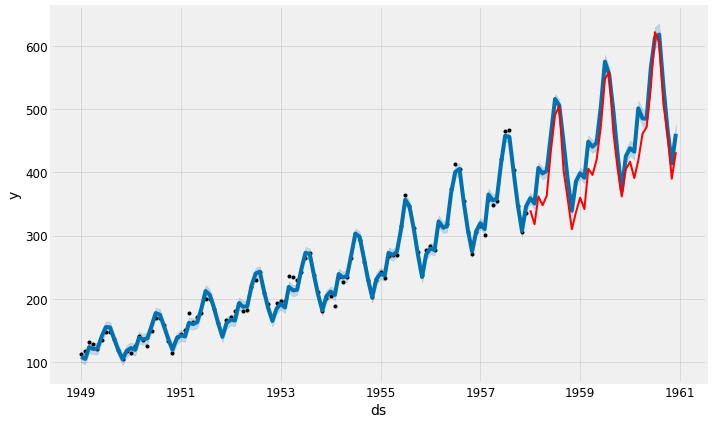

In [128]:
fig = model.plot(forecast)
#plot the predictions for validation set

plt.plot(valid, label='Valid', color = 'red', linewidth = 2)

plt.show()

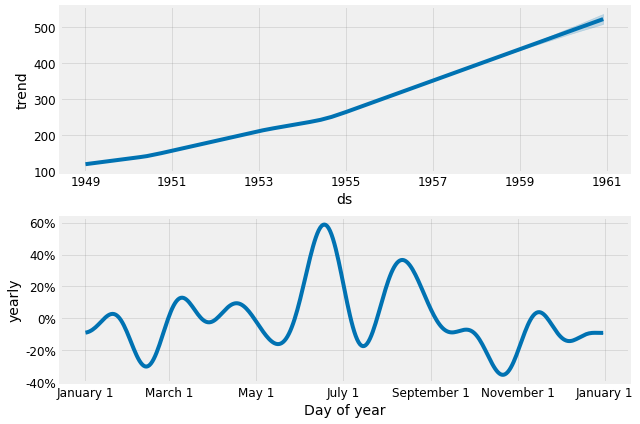

In [129]:
model.plot_components(forecast);

In [ ]:
y_prophet = y_prophet.set_index('ds')
forecast_prophet = forecast.set_index('ds')

In [ ]:
evaluate_forecast(y_prophet.y[start_index:end_index], forecast_prophet.yhat[start_index:end_index])